In [ ]:

import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yolo11-test/README.dataset.txt
/kaggle/input/yolo11-test/README.roboflow.txt
/kaggle/input/yolo11-test/data.yaml
/kaggle/input/yolo11-test/test/labels/DJI_0094_frame_00119_jpg.rf.fa3598e99baa5ab79ad7e9eb3e75ca39.txt
/kaggle/input/yolo11-test/test/labels/DJI_0093_frame_00004_jpg.rf.45d65b031bcbfac87cce4187c223122e.txt
/kaggle/input/yolo11-test/test/labels/DJI_0394_frame_00069_jpg.rf.333f7910ff901d8c848587936870d035.txt
/kaggle/input/yolo11-test/test/labels/DJI_0384_frame_00014_jpg.rf.1d15dadfb90cf0191bc61f1eca65a084.txt
/kaggle/input/yolo11-test/test/labels/DJI_0384_frame_00117_jpg.rf.596a85b663e813f146db54718c1d7b0d.txt
/kaggle/input/yolo11-test/test/labels/DJI_0384_frame_00053_jpg.rf.af52be0ef8ca23e0e08b2666b692a133.txt
/kaggle/input/yolo11-test/test/labels/DJI_0394_frame_00014_jpg.rf.fa1cc09029c08f69884517a58ea7ff6b.txt
/kaggle/input/yolo11-test/test/labels/DJI_0094_frame_00061_jpg.rf.8ff474b9fbf76492e73fb33b857eab85.txt
/kaggle/input/yolo11-test/test/labels/DJI_0384_fr

In [2]:
import os
import pandas as pd

image_dir = '/kaggle/input/rip-detection-v11/train/images'
label_dir = '/kaggle/input/rip-detection-v11/train/labels'

data = []

for img_name in os.listdir(image_dir):
    if not img_name.endswith(('.jpg', '.png')):
        continue

    image_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

    label = 1 if os.path.exists(label_path) and os.path.getsize(label_path) > 0 else 0
    data.append([image_path, label])
    
image_dir = '/kaggle/input/rip-detection-v11/valid/images'
label_dir = '/kaggle/input/rip-detection-v11/valid/labels'

for img_name in os.listdir(image_dir):
    if not img_name.endswith(('.jpg', '.png')):
        continue

    image_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

    label = 1 if os.path.exists(label_path) and os.path.getsize(label_path) > 0 else 0
    data.append([image_path, label])
    
df = pd.DataFrame(data, columns=['image_path', 'label'])
df.to_csv('image_labels.csv', index=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))



model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  
])

base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False


def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + \
                 (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy)
    return loss
    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
model.summary()


2025-06-27 20:10:59.298832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751055059.497039      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751055059.555293      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751055072.334676      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751055072.335370      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 4,467,713 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,                   
    rotation_range=20,               
    width_shift_range=0.3,          
    height_shift_range=0.3,          
    zoom_range=0.4,                  
    brightness_range=[0.5, 1.5],     
    horizontal_flip=True,           
    fill_mode='nearest'              
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',          
    monitor='val_loss',                
    save_best_only=True,               
    save_weights_only=False,           
    mode='min',                        
    verbose=1                          
)

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.utils import class_weight


df = pd.read_csv('/kaggle/working/image_labels.csv')

def load_and_preprocess_image(path):
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0  
    return img

images = np.array([load_and_preprocess_image(p) for p in df['image_path']])
labels = df['label'].values



from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.y),
    y=y_train
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)
callbacks = [
    checkpoint,
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(
    train_generator.x, train_generator.y,
    validation_data=(val_generator.x, val_generator.y),
    epochs=11,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


Class Weights: {0: 1.6590742101396032, 1: 0.715689381933439}
Epoch 1/11
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9310 - auc: 0.9791 - loss: 0.2079 - precision: 0.9647 - recall: 0.9353
Epoch 1: val_loss did not improve from 0.25039
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9309 - auc: 0.9791 - loss: 0.2080 - precision: 0.9647 - recall: 0.9352 - val_accuracy: 0.8965 - val_auc: 0.9509 - val_loss: 0.2708 - val_precision: 0.9332 - val_recall: 0.9125 - learning_rate: 1.2500e-06
Epoch 2/11
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9332 - auc: 0.9783 - loss: 0.2043 - precision: 0.9685 - recall: 0.9346
Epoch 2: val_loss did not improve from 0.25039
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9331 - auc: 0.9783 - loss: 0.2044 - precision: 0.9684 - recall: 0.9346 - val_accuracy: 0.8982 - val_auc: 0.9517 - val_loss: 0.2644 - val_precision: 0.9334 - val_recall: 0.9151 - learning_rate: 1.2500e-06
Epoch 3/11
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 

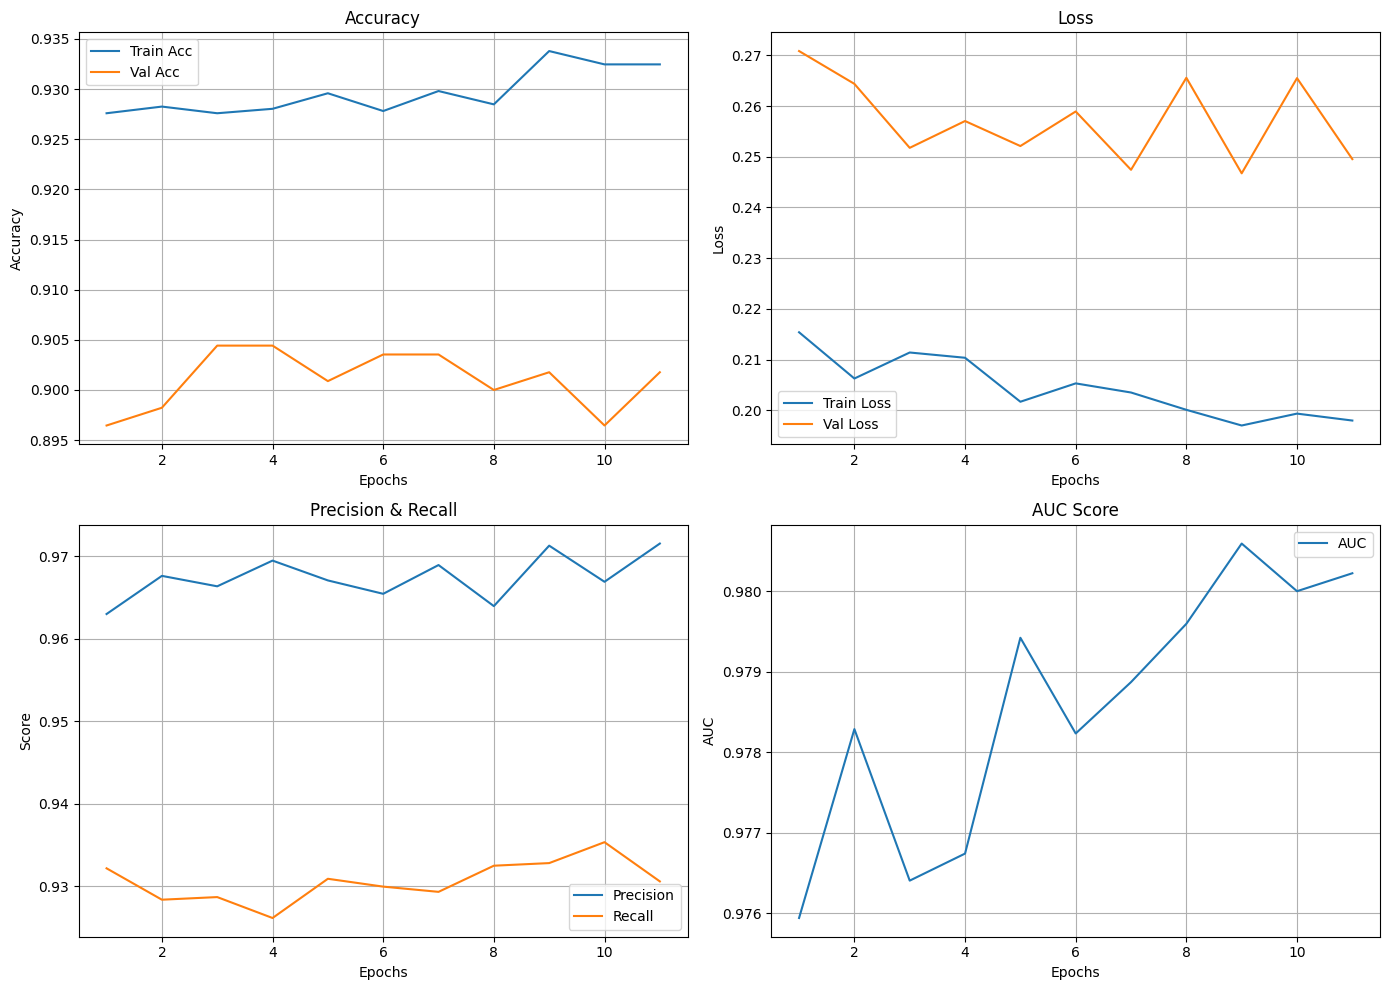

In [16]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, history_dict['accuracy'], label='Train Acc')
plt.plot(epochs, history_dict.get('val_accuracy', []), label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, history_dict['loss'], label='Train Loss')
plt.plot(epochs, history_dict.get('val_loss', []), label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
if 'precision' in history_dict:
    plt.plot(epochs, history_dict['precision'], label='Precision')
if 'recall' in history_dict:
    plt.plot(epochs, history_dict['recall'], label='Recall')
plt.title('Precision & Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
if 'auc' in history_dict:
    plt.plot(epochs, history_dict['auc'], label='AUC')
    plt.title('AUC Score')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [9]:
image_dir = '/kaggle/input/yolo11-test/test/images'
label_dir = '/kaggle/input/yolo11-test/test/labels'

data = []

for img_name in os.listdir(image_dir):
    if not img_name.endswith(('.jpg', '.png')):
        continue

    image_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

    label = 1 if os.path.exists(label_path) and os.path.getsize(label_path) > 0 else 0
    data.append([image_path, label])
    
df = pd.DataFrame(data, columns=['image_path', 'label'])
df.to_csv('vid_test_image_labels.csv', index=False)


tst = pd.read_csv('/kaggle/working/vid_test_image_labels.csv')
imgs = np.array([load_and_preprocess_image(p) for p in df['image_path']])
lbls = df['label'].values

# loss, accuracy = model.evaluate(imgs, lbls, batch_size=32)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

In [20]:
model.evaluate(imgs, lbls, batch_size=32)
'''print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")'''

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7660 - auc: 0.6802 - loss: 0.5049 - precision: 0.8761 - recall: 0.8510


'print(f"Validation Loss: {loss:.4f}")\nprint(f"Validation Accuracy: {accuracy:.4f}")'

In [ ]:
loss, accuracy = model.evaluate(imgs, lbls, batch_size=32)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")